### Calculating the sensitivity of SSAM output to small fluctuations in input
Quantifying differences in the output files of Salish Sea Atlantis Model simulations with small differences in input

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

#### Define scenario and control files

Files from the Scrubber discharge project with differences in start time

In [2]:
scenario2024l_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/Scrubber_discharge_100y_2024_latestart/outputSalishSea.nc"
scenario2024_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/Scrubber_discharge_100y_2024/outputSalishSea.nc"
scenario2029l_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/Scrubber_discharge_100y_2029_latestart/outputSalishSea.nc"
scenario2029_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/Scrubber_discharge_100y_2029/outputSalishSea.nc"

scenario2024l = xr.open_dataset(str(scenario2024l_file), decode_cf=True)
scenario2024 = xr.open_dataset(str(scenario2024_file), decode_cf=True)
scenario2029l = xr.open_dataset(str(scenario2029l_file), decode_cf=True)
scenario2029 = xr.open_dataset(str(scenario2029_file), decode_cf=True)

Files resulting from increased initial biomass of select biological functional groups

In [3]:
scenario_BC_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/butterflyeffect_BCx2/outputSalishSea.nc"
scenario_FHE_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/butterflyeffect_FHEx2/outputSalishSea.nc"
scenario_MA_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/butterflyeffect_MAx2/outputSalishSea.nc"
scenario_ORR_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/butterflyeffect_ORRx2/outputSalishSea.nc"
scenario_PL_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/butterflyeffect_PLx2/outputSalishSea.nc"
scenario_PS_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/butterflyeffect_PSx2/outputSalishSea.nc"
scenario_WHB_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/butterflyeffect_WHBx2/outputSalishSea.nc"
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/control/outputSalishSea.nc"

scenario_BC = xr.open_dataset(str(scenario_BC_file), decode_cf=True)
scenario_FHE = xr.open_dataset(str(scenario_FHE_file), decode_cf=True)
scenario_MA = xr.open_dataset(str(scenario_MA_file), decode_cf=True)
scenario_ORR = xr.open_dataset(str(scenario_ORR_file), decode_cf=True)
scenario_PL = xr.open_dataset(str(scenario_PL_file), decode_cf=True)
scenario_PS = xr.open_dataset(str(scenario_PS_file), decode_cf=True)
scenario_WHB = xr.open_dataset(str(scenario_WHB_file), decode_cf=True)
control= xr.open_dataset(str(control_file), decode_cf=True)

time = np.ma.filled(control.variables['t'], np.nan)

In [5]:
start = 0 #40
end =  time.size-1 #120 

event_start = np.datetime64('2019-08-01')

Phenanthrene concentrations in each scenario

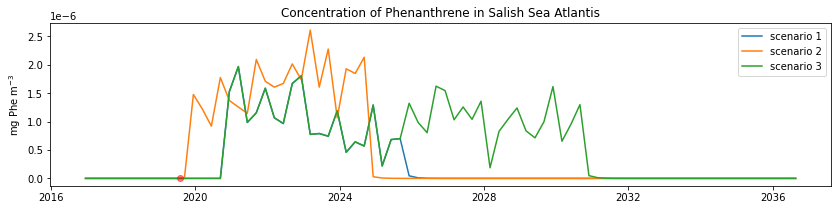

In [6]:
splot.plot_pah('Phenanthrene', scenario2024l, scenario2024, scenario2029l, time, start, end, event_start)

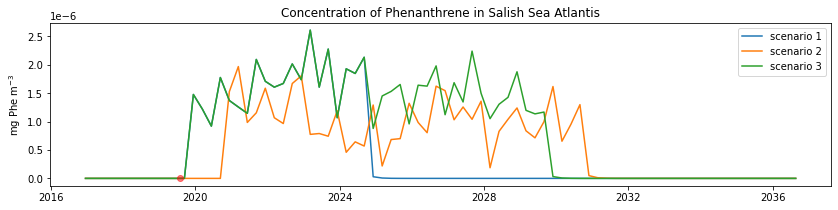

In [7]:
splot.plot_pah('Phenanthrene', scenario2024, scenario2029l, scenario2029, time, start, end, event_start)

Lower trophic levels

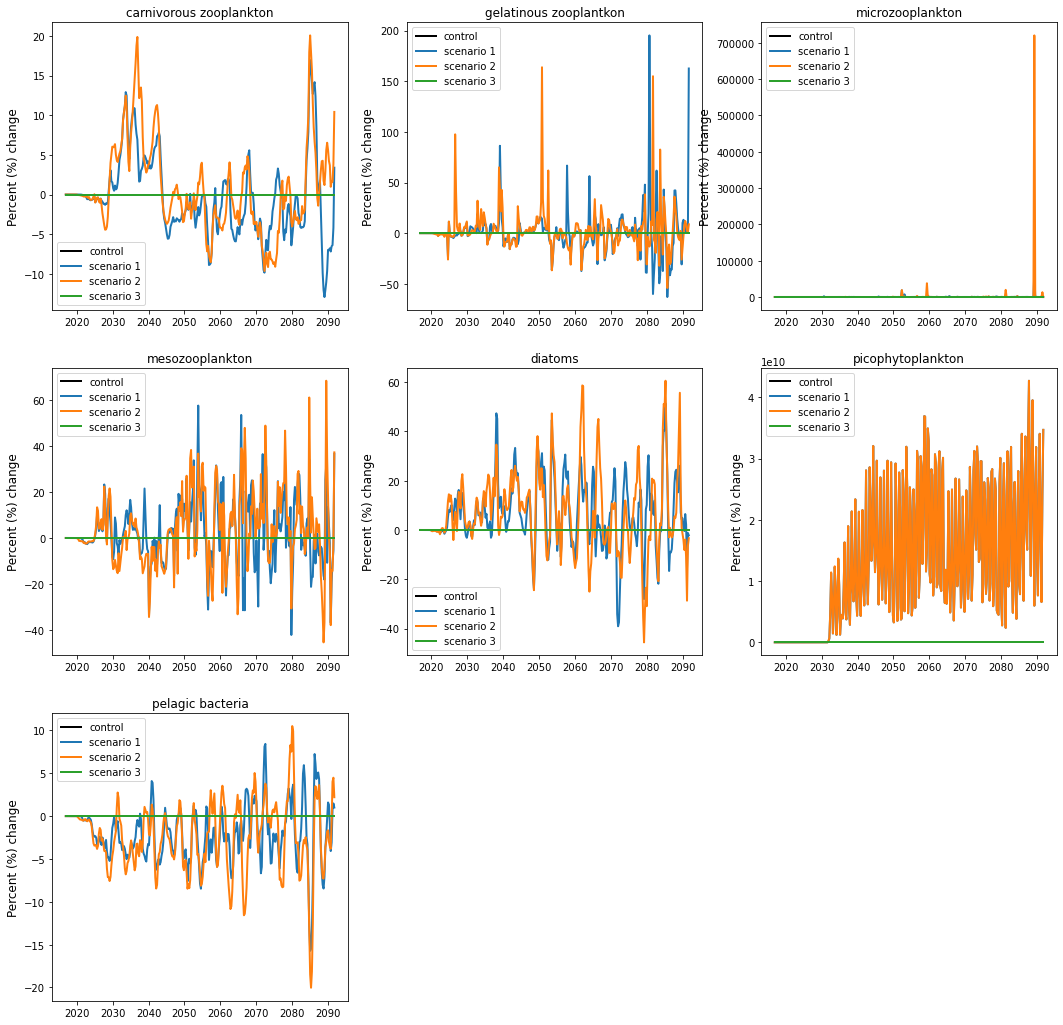

In [4]:
splot.pelagic_compare_scenarios(groups.plankton, scenario2024l, scenario2024, control, control, time, start, end)

In [17]:
def my_rmse(one, two):
    #averaged over the water column
    one = one.mean(axis=2)
    two = two.mean(axis=2)
    one = one.mean(axis=1)
    two = two.mean(axis=1)
    one = one.mean(axis=0)
    two = two.mean(axis=0)

    #RMSE
    rmse = ((one - two)**2)**(1/2)
    return rmse

In [18]:
one = control.variables['MicroZoo_N'][start:end][:]
two = scenario_MA.variables['MicroZoo_N'][start:end][:]

my_rmse(one, two)

<xarray.Variable ()>
array(0.02322177)